# **Import libraries**

In [1]:

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Import XGBRegressor directly
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
def compute_metrics(true, pred, name="Model"):
    """
    Compute MAE, RMSE, and R². Print a warning if R² < 0.
    Returns (MAE, RMSE, R²).
    """
    mae  = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2   = r2_score(true, pred)
    if r2 < 0:
        print(f"⚠️  {name} has negative R² = {r2:.4f}")
    else:
        print(f"{name} R² = {r2:.4f}")
    print(f"{name} MAE  = {mae:.4f}")
    print(f"{name} RMSE = {rmse:.4f}\n")
    return mae, rmse, r2

# **Read Data Set**

In [3]:

file_path = "/content/who_aap_2021_v9_11august2022.xlsx"
df_aap    = pd.read_excel(file_path, sheet_name="AAP_2022_city_v9")

In [4]:
df_aap

,WHO Region,ISO3,WHO Country Name,City or Locality,Measurement Year,PM2.5 (μg/m3),PM10 (μg/m3),NO2 (μg/m3),PM25 temporal coverage (%),PM10 temporal coverage (%),NO2 temporal coverage (%),Reference,Number and type of monitoring stations,Version of the database,Status
0,Eastern Mediterranean Region,AFG,Afghanistan,Kabul,2019,119.77,NaN,NaN,18.0,NaN,NaN,"U.S. Department of State, United States Enviro...",NaN,2022,NaN
1,European Region,ALB,Albania,Durres,2015,NaN,17.65,26.63,NaN,NaN,83.961187,European Environment Agency (downloaded in 2021),NaN,2022,NaN
2,European Region,ALB,Albania,Durres,2016,14.32,24.56,24.78,NaN,NaN,87.932605,European Environment Agency (downloaded in 2021),NaN,2022,NaN
3,European Region,ALB,Albania,Elbasan,2015,NaN,NaN,23.96,NaN,NaN,97.853881,European Environment Agency (downloaded in 2021),NaN,2022,NaN
4,European Region,ALB,Albania,Elbasan,2016,NaN,NaN,26.26,NaN,NaN,96.049636,European Environment Agency (downloaded in 2021),NaN,2022,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32186,African Region,ZAF,South Africa,West Coast,2015,7.47,24.64,7.64,75.0,75.0,75.000000,South African Air Quality Information System,3 Residential-Medium/Upper income,2022,NaN
32187,African Region,ZAF,South Africa,West Coast,2016,8.42,33.28,7.27,75.0,75.0,75.000000,South African Air Quality Information System,2 Residential-Medium/Upper income,2022,NaN
32188,African Region,ZAF,South Africa,West Coast,2017,6.83,20.49,8.72,75.0,75.0,75.000000,South African Air Quality Information System,2 Residential-Medium/Upper income,2022,NaN
32189,African Region,ZAF,South Africa,West Coast,2018,6.10,17.99,7.15,75.0,75.0,75.000000,South African Air Quality Information System,2 Residential-Medium/Upper income,2022,NaN


# **Filter the Indian DataFrame**

In [5]:


# Filter to India and select relevant columns
df_cn = df_aap[df_aap["WHO Country Name"] == "China"].copy()
df_cn = df_cn[[
    "City or Locality",
    "Measurement Year",
    "PM2.5 (μg/m3)",
    "PM10 (μg/m3)",
    "NO2 (μg/m3)"
]].reset_index(drop=True)

df_cn = df_cn.rename(columns={
    "PM2.5 (μg/m3)": "PM2.5",
    "PM10 (μg/m3)":  "PM10",
    "NO2 (μg/m3)":   "NO2"
})
df_cn["Measurement Year"] = pd.to_datetime(df_cn["Measurement Year"], format="%Y")
df_cn["Year"]              = df_cn["Measurement Year"].dt.year.astype(int)


In [6]:
df_cn

,City or Locality,Measurement Year,PM2.5,PM10,NO2,Year
0,Aba,2017-01-01,11.67,NaN,NaN,2017
1,Aba,2018-01-01,13.00,NaN,NaN,2018
2,Aba Zangzu Qiangzu Zizhizhou,2018-01-01,15.36,NaN,NaN,2018
3,Aba Zangzu Qiangzu Zizhizhou,2019-01-01,18.47,NaN,NaN,2019
4,Acheng Qu,2018-01-01,37.45,NaN,NaN,2018
...,...,...,...,...,...,...
3962,Zunyi,2016-01-01,44.32,NaN,32.0,2016
3963,Zunyi,2017-01-01,33.50,NaN,NaN,2017
3964,Zunyi,2018-01-01,27.00,NaN,NaN,2018
3965,Zunyi Shi,2018-01-01,27.98,NaN,NaN,2018


# **EXPLORATORY DATA ANALYSIS (EDA)**

In [7]:
print("=== Descriptive Statistics for Pollutants (India) ===")
display(df_cn[["PM2.5", "PM10", "NO2"]].describe())

=== Descriptive Statistics for Pollutants (India) ===


,PM2.5,PM10,NO2
count,3966.000000,43.000000,285.000000
mean,43.072988,72.614651,36.521789
std,16.356075,42.719165,11.101220
min,7.000000,27.740000,11.000000
25%,31.365000,33.520000,29.000000
50%,41.490000,66.000000,36.000000
75%,53.115000,108.000000,45.000000
max,156.320000,190.000000,63.000000


In [8]:


n_stations = df_cn["City or Locality"].nunique()
print(f"Number of distinct monitoring locations: {n_stations}\n")


Number of distinct monitoring locations: 1429



In [9]:

counts_per_year = df_cn.groupby("Year").size().to_frame(name="Count")
print("Number of station-year observations per Year:")
display(counts_per_year)

Number of station-year observations per Year:


,Count
Year,
2011,3
2012,5
2013,10
2014,213
2015,545
2016,550
2017,370
2018,1299
2019,972


In [10]:

print("\n=== Missing Values Count ===")
display(df_cn[["PM2.5", "PM10", "NO2"]].isna().sum())



=== Missing Values Count ===


,0
PM2.5,1
PM10,3924
NO2,3682


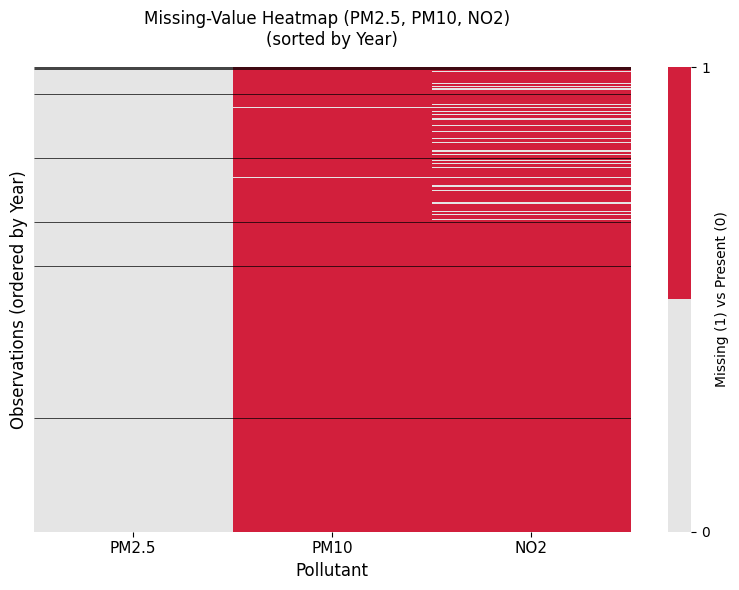

<Figure size 1000x500 with 0 Axes>

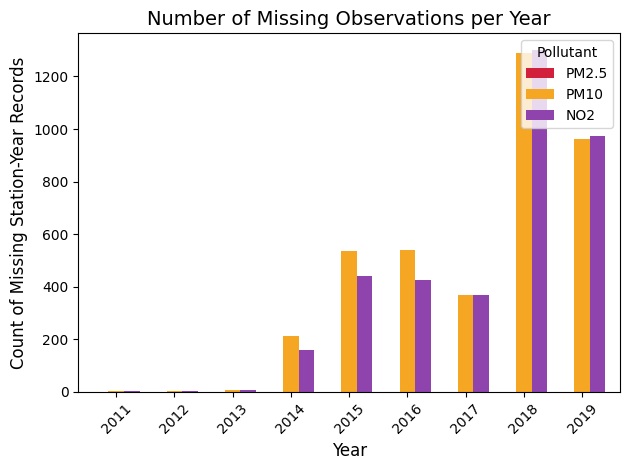

<Figure size 1000x500 with 0 Axes>

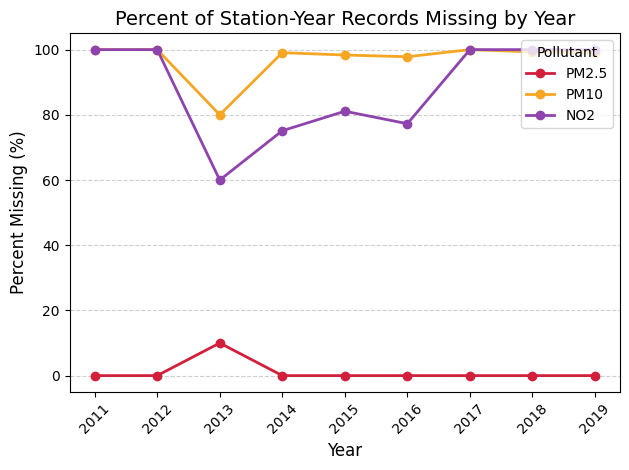

In [11]:

# ─── 1. SORT THE DATAFRAME BY YEAR ─────────────────────────────────────────────
# Assume `df_cn` already exists with a "Year" column.
df_cn_sorted = df_cn.sort_values("Year").reset_index(drop=True)

# Create a boolean mask: True if missing, False if present
missing_mask_sorted = df_cn_sorted[["PM2.5", "PM10", "NO2"]].isnull()

# ─── 2. PLOT A CUSTOM HEATMAP (SORTED BY YEAR, RED FOR MISSING) ────────────────
plt.figure(figsize=(8, 6))

# Define a two‐color palette: light gray = present (False), red = missing (True)
# We specify vmin=0, vmax=1 so that False→0, True→1.
cmap = sns.color_palette(["#E5E5E5", "#D21F3C"])

ax = sns.heatmap(
    missing_mask_sorted.astype(int),  # convert True/False to 1/0
    cbar=True,
    cmap=cmap,
    vmin=0,
    vmax=1,
    yticklabels=False,               # hide individual row labels
    cbar_kws={"ticks": [0, 1], "label": "Missing (1) vs Present (0)"}
)

# Format plot labels
ax.set_title("Missing‐Value Heatmap (PM2.5, PM10, NO2)  \n(sorted by Year)", pad=16)
ax.set_xlabel("Pollutant", fontsize=12)
ax.set_ylabel("Observations (ordered by Year)", fontsize=12)
ax.set_xticklabels(["PM2.5", "PM10", "NO2"], rotation=0, fontsize=11)

# ─── 3. ADD HORIZONTAL LINES TO SEPARATE YEARS ─────────────────────────────────
# Count how many rows belong to each year, in ascending order
counts_per_year = df_cn_sorted["Year"].value_counts().sort_index().values
# Compute the cumulative sum so we know where each year block ends
cumulative_counts = np.cumsum(counts_per_year)

# Draw a thin horizontal line at each boundary between years (skip the final boundary at bottom)
for boundary in cumulative_counts[:-1]:
    ax.hlines(y=boundary, xmin=0, xmax=3, colors="black", linewidth=0.5)

plt.tight_layout()
plt.show()


# ─── 4. OPTIONAL: SUMMARY BAR CHART OF MISSING COUNTS BY YEAR ───────────────────
# If you also want a quick bar chart showing absolute missing‐value counts per year:
missing_by_year = df_cn_sorted.groupby("Year")[["PM2.5", "PM10", "NO2"]].apply(lambda df: df.isnull().sum())

plt.figure(figsize=(10, 5))
missing_by_year.plot(
    kind="bar",
    stacked=False,
    color=["#D21F3C", "#F5A623", "#8F44AD"],  # red, orange, purple
    width=0.8
)
plt.title("Number of Missing Observations per Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Count of Missing Station‐Year Records", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Pollutant", loc="upper right")
plt.tight_layout()
plt.show()


# ─── 5. OPTIONAL: PERCENT MISSING‐BY‐YEAR LINE PLOT ─────────────────────────────
# If you’d like to see what fraction of the stations are missing each pollutant per year:
counts_total = df_cn_sorted.groupby("Year").size().rename("Total")
pct_missing_by_year = missing_by_year.div(counts_total, axis=0) * 100

plt.figure(figsize=(10, 5))
pct_missing_by_year.plot(
    kind="line",
    marker="o",
    linewidth=2,
    markersize=6,
    color=["#D21F3C", "#F5A623", "#8F44AD"]
)
plt.title("Percent of Station‐Year Records Missing by Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percent Missing (%)", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Pollutant", loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'PM2.5 Distribution')

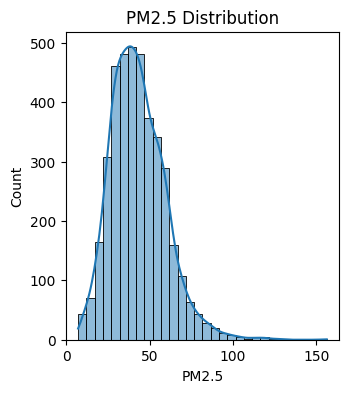

In [12]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(df_cn["PM2.5"].dropna(), bins=30, kde=True)
plt.title("PM2.5 Distribution")

Text(0.5, 1.0, 'PM10 Distribution')

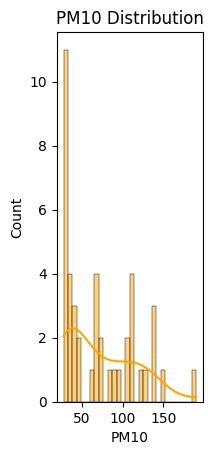

In [13]:

plt.subplot(1, 3, 2)
sns.histplot(df_cn["PM10"].dropna(), bins=30, kde=True, color="orange")
plt.title("PM10 Distribution")

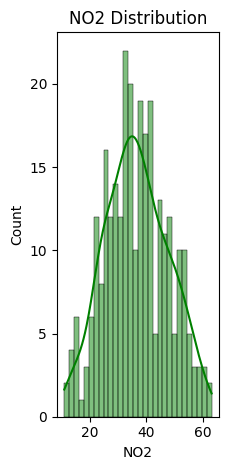

In [14]:
plt.subplot(1, 3, 3)
sns.histplot(df_cn["NO2"].dropna(), bins=30, kde=True, color="green")
plt.title("NO2 Distribution")

plt.tight_layout()
plt.show()

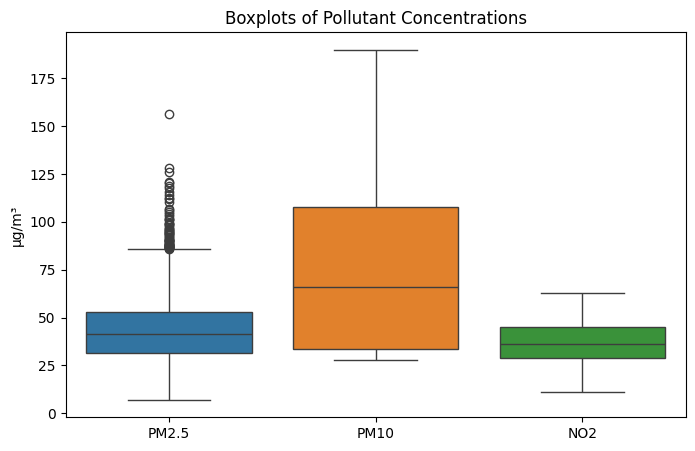

In [15]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_cn[["PM2.5", "PM10", "NO2"]])
plt.title("Boxplots of Pollutant Concentrations")
plt.ylabel("µg/m³")
plt.show()

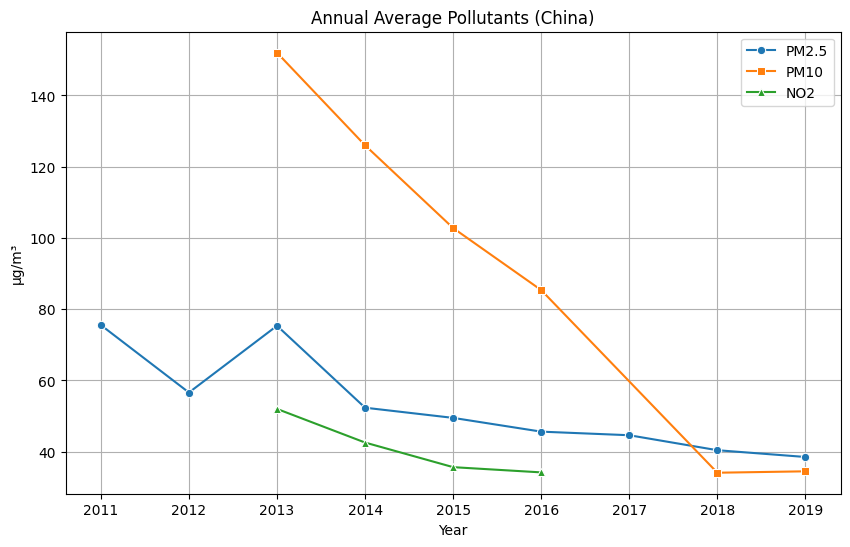

In [16]:
annual_avg = df_cn.groupby("Year")[["PM2.5", "PM10", "NO2"]].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=annual_avg, x="Year", y="PM2.5", marker="o", label="PM2.5")
sns.lineplot(data=annual_avg, x="Year", y="PM10", marker="s", label="PM10")
sns.lineplot(data=annual_avg, x="Year", y="NO2", marker="^", label="NO2")
plt.title("Annual Average Pollutants (China)")
plt.xlabel("Year")
plt.ylabel("µg/m³")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Compute correlation matrix (station-level observations)
corr_matrix = df_cn[["PM2.5", "PM10", "NO2"]].corr()
print("=== Correlation Matrix (Station-Level) ===")
print(corr_matrix, "\n")


=== Correlation Matrix (Station-Level) ===
          PM2.5      PM10       NO2
PM2.5  1.000000  0.971974  0.714754
PM10   0.971974  1.000000  0.891344
NO2    0.714754  0.891344  1.000000 



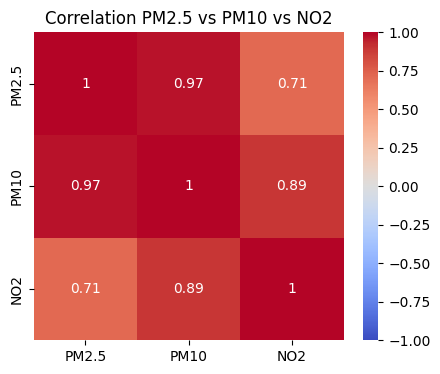

In [18]:
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation PM2.5 vs PM10 vs NO2")
plt.show()


In [19]:

corr_matrix = df_cn[["PM2.5", "PM10", "NO2"]].corr()
print("=== Correlation Matrix ===")
display(corr_matrix)

=== Correlation Matrix ===


,PM2.5,PM10,NO2
PM2.5,1.000000,0.971974,0.714754
PM10,0.971974,1.000000,0.891344
NO2,0.714754,0.891344,1.000000


In [20]:
city_avg = df_cn.groupby("City or Locality")["PM2.5"].mean() \
                  .sort_values(ascending=False).reset_index()
city_avg.columns = ["City or Locality", "Avg_PM2.5"]
top10_cities = city_avg.head(10)
print("=== Top 10 Cities by Avg PM2.5 (All Years) ===")
display(top10_cities)

=== Top 10 Cities by Avg PM2.5 (All Years) ===


,City or Locality,Avg_PM2.5
0,Kashi Shi,109.200000
1,Hotan,108.390000
2,Hetian Shi,106.505000
3,Hetian,105.500000
4,Kashgar,102.506667
5,Baoding,94.936000
6,Xingtai,93.274000
7,Shijiazhuang,91.506000
8,Ji'nan,90.000000
9,Handan,87.644000


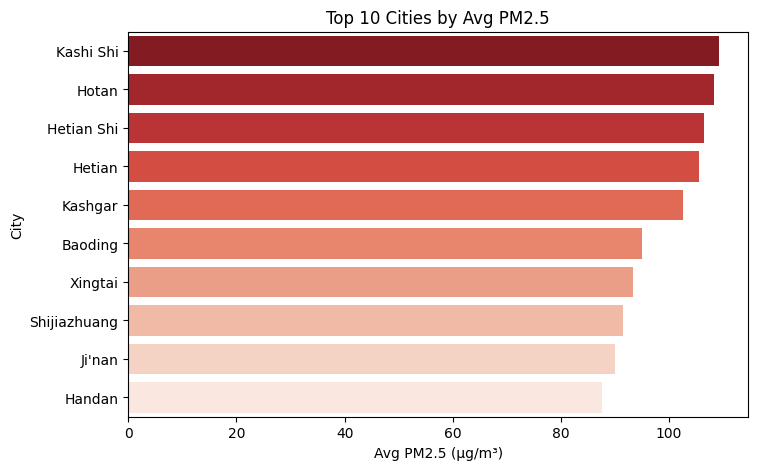

In [21]:
plt.figure(figsize=(8, 5))
sns.barplot(data=top10_cities, x="Avg_PM2.5", y="City or Locality", palette="Reds_r")
plt.title("Top 10 Cities by Avg PM2.5")
plt.xlabel("Avg PM2.5 (µg/m³)")
plt.ylabel("City")
plt.show()


In [22]:

latest_year = df_cn["Year"].max()
latest_df   = df_cn[df_cn["Year"] == latest_year]
latest_top5 = latest_df.groupby("City or Locality")["PM2.5"] \
                       .mean().sort_values(ascending=False).head(5).reset_index()
latest_top5.columns = ["City or Locality", f"PM2.5_{latest_year}"]
print(f"=== Top 5 Cities by PM2.5 in {latest_year} ===")
display(latest_top5)

=== Top 5 Cities by PM2.5 in 2019 ===


,City or Locality,PM2.5_2019
0,Hetian Shi,112.30
1,Kashgar,90.23
2,Zhanhe Qu,89.60
3,Shunhe Huizuqu,88.27
4,"Xinfu District, Xinzhou",83.39


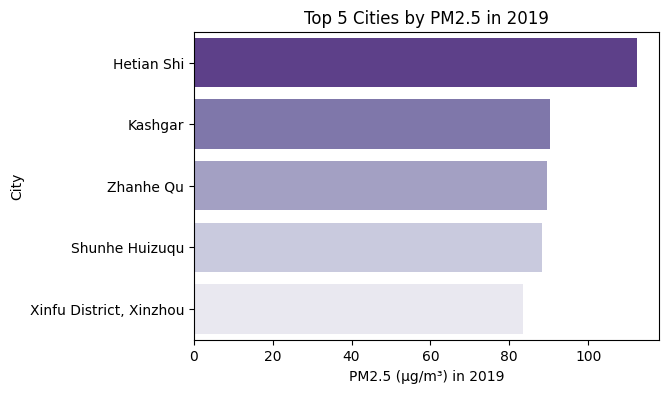

In [23]:

plt.figure(figsize=(6, 4))
sns.barplot(data=latest_top5, x=f"PM2.5_{latest_year}", y="City or Locality", palette="Purples_r")
plt.title(f"Top 5 Cities by PM2.5 in {latest_year}")
plt.xlabel(f"PM2.5 (µg/m³) in {latest_year}")
plt.ylabel("City")
plt.show()

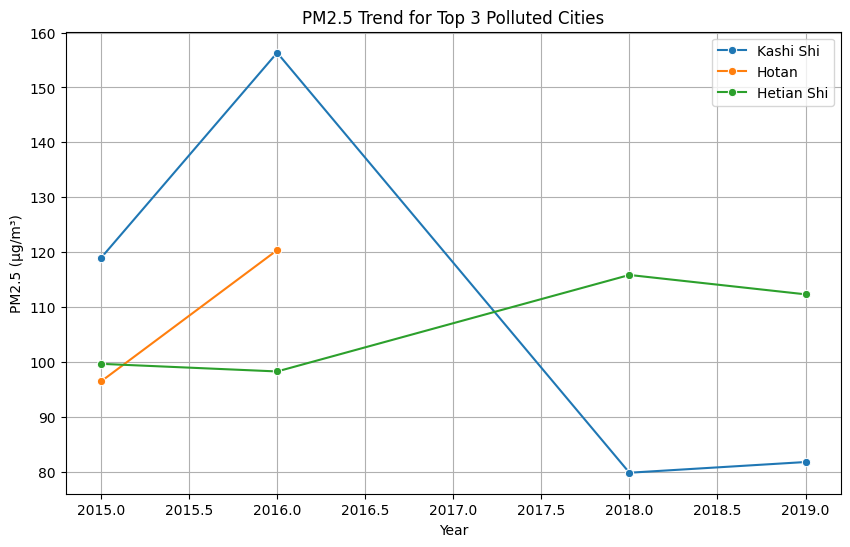

In [24]:
sample_cities = top10_cities["City or Locality"].iloc[:3].tolist()
plt.figure(figsize=(10, 6))
for city in sample_cities:
    city_df = df_cn[df_cn["City or Locality"] == city] \
               .groupby("Year")["PM2.5"].mean().reset_index()
    sns.lineplot(data=city_df, x="Year", y="PM2.5", marker="o", label=city)
plt.title("PM2.5 Trend for Top 3 Polluted Cities")
plt.xlabel("Year")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.grid(True)
plt.show()

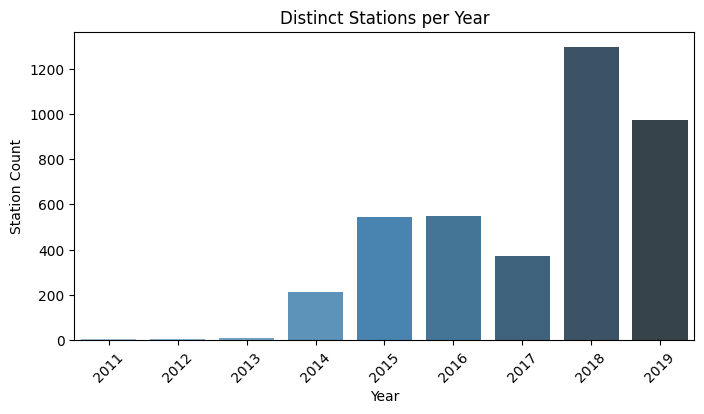

In [25]:

stations_per_year = df_cn.groupby("Year")["City or Locality"].nunique().reset_index()
stations_per_year.columns = ["Year", "Num_Stations"]
plt.figure(figsize=(8, 4))
sns.barplot(data=stations_per_year, x="Year", y="Num_Stations", palette="Blues_d")
plt.title("Distinct Stations per Year")
plt.xlabel("Year")
plt.ylabel("Station Count")
plt.xticks(rotation=45)
plt.show()

# **Final Code**

Best hyperparameters: {'subsample': np.float64(0.7), 'n_estimators': np.int64(300), 'max_depth': np.int64(3), 'learning_rate': np.float64(0.042222222222222223), 'colsample_bytree': np.float64(0.7)}

China Station-Level Forecast (XGBoost) Performance:
 MAE  = 5.66 µg/m³
 RMSE = 7.21 µg/m³
 R²   = 0.7454


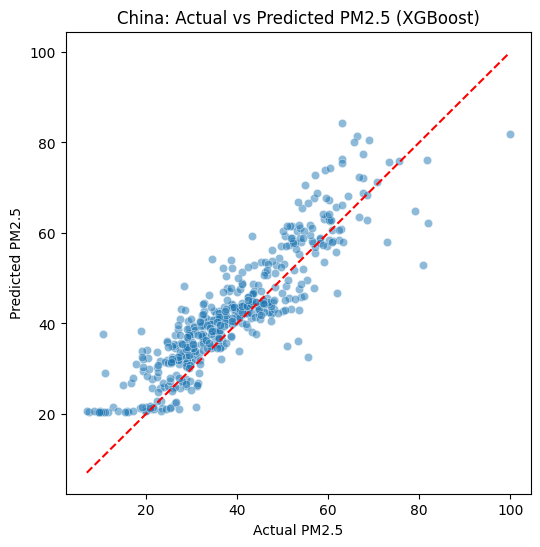

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import os
# Update the file path to your Drive location
# file_path = '/content/who_aap_2021_v9_11august2022.xlsx'


# # 2. Read the "AAP_2022_city_v9" sheet
# df = pd.read_excel(file_path, sheet_name="AAP_2022_city_v9")

# 3. Filter to China
# df_cn = df[df["WHO Country Name"] == "China"].copy()
df_cn = df_cn.rename(columns={
    "PM2.5 (μg/m3)": "PM2.5",
    "PM10 (μg/m3)":  "PM10",
    "NO2 (μg/m3)":   "NO2"
})
df_cn["Measurement Year"] = pd.to_datetime(df_cn["Measurement Year"], format="%Y")
df_cn["Year"] = df_cn["Measurement Year"].dt.year


#  Preprocessing: Impute and winsorize PM2.5 only
df_cn["PM2.5"] = (
    df_cn.groupby("City or Locality")["PM2.5"]
         .transform(lambda x: x.fillna(x.mean()))
).fillna(df_cn["PM2.5"].mean())
thr = df_cn["PM2.5"].quantile(0.995)
df_cn["PM2.5"] = np.where(df_cn["PM2.5"] > thr, thr, df_cn["PM2.5"])

#  Create 1-3 year lag features for PM2.5 per station
df_cn = df_cn.sort_values(["City or Locality","Measurement Year"]).reset_index(drop=True)
for lag in (1,2,3):
    df_cn[f"PM2.5_lag_{lag}"] = df_cn.groupby("City or Locality")["PM2.5"].shift(lag)
df_cn = df_cn.dropna(subset=[f"PM2.5_lag_{lag}" for lag in (1,2,3)])

#  Prepare features & target
features = [f"PM2.5_lag_{lag}" for lag in (1,2,3)]
X = df_cn[features]
y = df_cn["PM2.5"]

# 10. Train-test split (by year: 60% train / 40% test)
years = sorted(df_cn["Year"].unique())
split_idx = int(len(years)*0.6)
split_year = years[split_idx]
train_idx = df_cn["Year"] <= split_year
test_idx  = df_cn["Year"] > split_year

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

#  Hyperparameter tuning with RandomizedSearchCV for XGBoost
param_dist = {
    'n_estimators': np.arange(50, 501, 50),
    'max_depth': np.arange(3, 11, 1),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5)
}

xgb = XGBRegressor(random_state=42, objective="reg:squarederror")
search = RandomizedSearchCV(
    xgb, param_distributions=param_dist,
    n_iter=20, cv=3, scoring='neg_root_mean_squared_error',
    n_jobs=-1, random_state=42
)
search.fit(X_train, y_train)

best_model = search.best_estimator_
print("Best hyperparameters:", search.best_params_)

#  Evaluate on test set
pred = best_model.predict(X_test)
mae  = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2   = r2_score(y_test, pred)

print(f"\nChina Station-Level Forecast (XGBoost) Performance:")
print(f" MAE  = {mae:.2f} µg/m³")
print(f" RMSE = {rmse:.2f} µg/m³")
print(f" R²   = {r2:.4f}")

# 13. Scatter plot of actual vs. predicted
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=pred, alpha=0.5)
lims = [min(y_test.min(), pred.min()), max(y_test.max(), pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("China: Actual vs Predicted PM2.5 (XGBoost)")
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


,Model,MAE,RMSE,R2
0,XGBoost,5.656410,7.208889,0.745441
1,RandomForest,5.494186,6.960256,0.762698
2,MLPRegressor,4.623416,6.272379,0.807285
3,"ARIMA(1,1,1)",1.517361,2.078860,0.702640


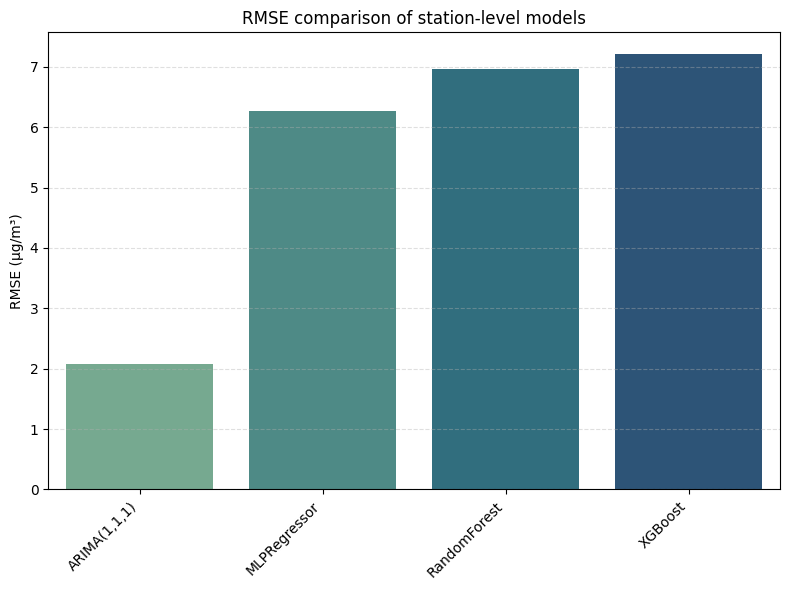

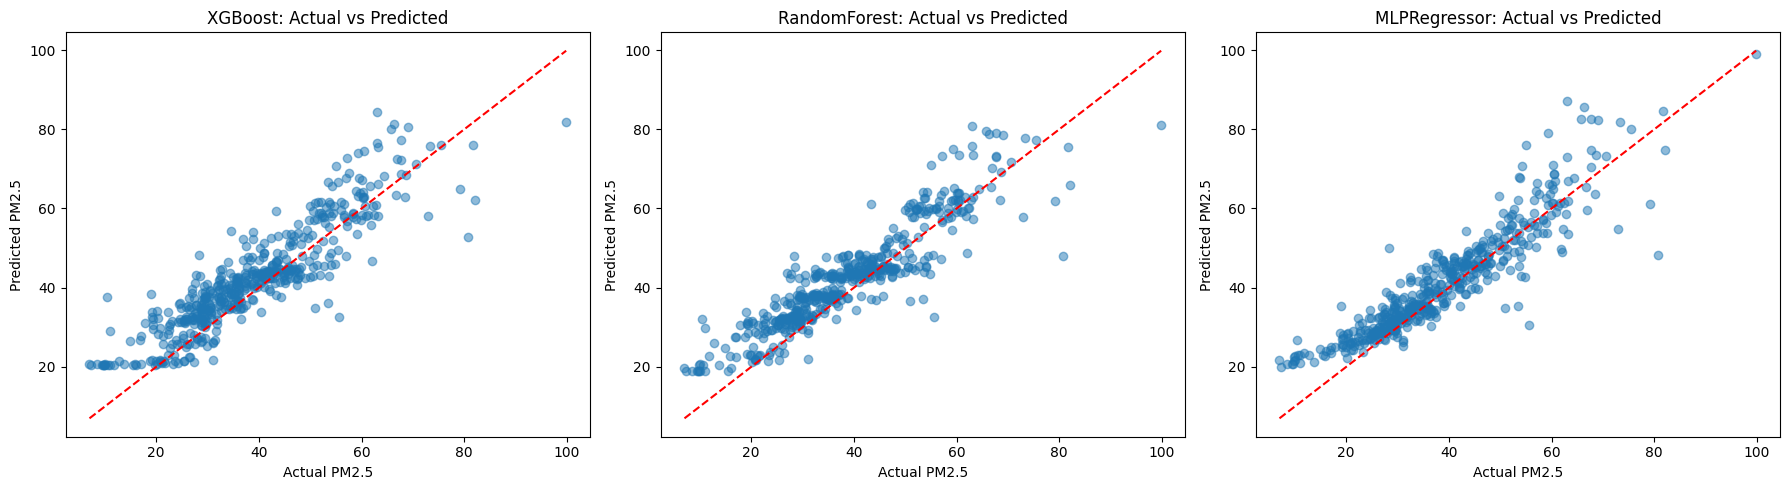

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.api as sm

# 1. Load preprocessed China data (assumes `df_cn` from earlier cell)
#    If running standalone, re-run preprocessing steps to obtain df_cn with:
#    columns ["City or Locality","Measurement Year","Year","PM2.5", "PM2.5_lag_1/2/3"].

# For demonstration, let's assume df_cn is already in workspace:
# df_cn = ...

# 2. Train/test split by Year (60/40)
years = sorted(df_cn["Year"].unique())
split_idx = int(len(years)*0.6)
split_year = years[split_idx]

train_df = df_cn[df_cn["Year"] <= split_year].copy()
test_df  = df_cn[df_cn["Year"] >  split_year].copy()

feature_cols = [f"PM2.5_lag_{lag}" for lag in (1,2,3)]
X_train = train_df[feature_cols].values
y_train = train_df["PM2.5"].values
X_test  = test_df[feature_cols].values
y_test  = test_df["PM2.5"].values

# 3. Model 1: XGBoost
xgb = XGBRegressor(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.0422,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    objective="reg:squarederror"
)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)

# 4. Model 2: Random Forest
rf = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

# 5. Model 3: MLP Neural Network
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

mlp = MLPRegressor(
    hidden_layer_sizes=(64,32),
    activation="relu",
    solver="adam",
    max_iter=500,
    random_state=42
)
mlp.fit(X_train_s, y_train)
pred_mlp = mlp.predict(X_test_s)

# 6. Model 4: ARIMA on aggregated series
#    Build annual aggregated PM2.5 series
agg_series = df_cn.groupby("Measurement Year")["PM2.5"].mean().sort_index()
train_series = agg_series[agg_series.index.year <= split_year]
test_series  = agg_series[agg_series.index.year >  split_year]

# Simple ARIMA(1,1,1) fit
arima_mod = sm.tsa.ARIMA(train_series, order=(1,1,1)).fit()
pred_arima = arima_mod.forecast(steps=len(test_series))
pred_arima.index = test_series.index

# 7. Evaluation
def eval_model(true, pred, name):
    mae  = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2   = r2_score(true, pred)
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2}

results = []
results.append(eval_model(y_test,    pred_xgb,  "XGBoost"))
results.append(eval_model(y_test,    pred_rf,   "RandomForest"))
results.append(eval_model(y_test,    pred_mlp,  "MLPRegressor"))
# For ARIMA, compare on aggregated test_series
results.append(eval_model(test_series.values, pred_arima.values, "ARIMA(1,1,1)"))

results_df = pd.DataFrame(results)
display(results_df)

# 8. Bar-plot comparison of station-level models
plt.figure(figsize=(8,6))

# sort so the best (lowest RMSE) appears first, optional
order = results_df.sort_values("RMSE")["Model"]

sns.barplot(data=results_df,
            x="Model",
            y="RMSE",
            order=order,
            palette="crest")

plt.title("RMSE comparison of station-level models")
plt.ylabel("RMSE (µg/m³)")
plt.xlabel("")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


# 9. Scatter plots
fig, axes = plt.subplots(1,3, figsize=(18,5))
for ax, (pred, title) in zip(axes,
                             [(pred_xgb,"XGBoost"), (pred_rf,"RandomForest"), (pred_mlp,"MLPRegressor")]):
    ax.scatter(y_test, pred, alpha=0.5)
    lims = [min(y_test.min(), pred.min()), max(y_test.max(), pred.max())]
    ax.plot(lims, lims, 'r--')
    ax.set_title(f"{title}: Actual vs Predicted")
    ax.set_xlabel("Actual PM2.5")
    ax.set_ylabel("Predicted PM2.5")
plt.tight_layout()
plt.show()

